## To do list:

1) Make preprocessing, trends, concordance, naive_n_gram_analysis, targeted_n_gram_analysis into single functions 

2) Compile all functions into classes

3) Bag of words approach

4) tifdf approach

5) words to vec approach

6) Fit Random Forest to data? 

In [105]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pylab
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import *
import matplotlib.colors as cm

In [2]:
# load dataframe
data = pd.read_csv('abstracts.csv', low_memory= False)
pmiddf = pd.DataFrame(data['PMID'])
data = pd.DataFrame(data.set_index('PMID'))
data.head()

,AB
PMID,
27116719,"Recently, there have been major advances in th..."
27116717,Although genetic susceptibility explains the c...
27116242,"Beyond effects on bone health, vitamin D exert..."
27108944,Ultraviolet B (UVB) light suppresses the devel...
27107558,Vitamin D3 regulates genes critical for human ...


In [84]:
len(data.index)

2261

In [3]:
### Define Preprocessing:
'''
Input: pd series of abstracts
Output: list of abstracts- lowercase, tokanized, stopwords removed 
'''
def preprocess_abstracts(abstract_series):
    stopWords = stopwords.words('english')+['.', '(', ')', '=', ',', '-', '%', ':', 'in']
    lowercaseData= abstract_series.str.lower()
    splitdata = lowercaseData.apply(word_tokenize)
    stopped = splitdata.apply(lambda x: [item for item in x if item not in stopWords])
    return stopped

In [4]:
processeddata = preprocess_abstracts(data['AB'])

In [5]:
processeddata.head()

PMID
27116719    [recently, major, advances, development, disea...
27116717    [although, genetic, susceptibility, explains, ...
27116242    [beyond, effects, bone, health, vitamin, exert...
27108944    [ultraviolet, b, uvb, light, suppresses, devel...
27107558    [vitamin, d3, regulates, genes, critical, huma...
Name: AB, dtype: object

In [6]:
# to join all abstracts

allabstracts = [x for x in data['AB'].str.lower()]
joinedText = '\n'.join(allabstracts)

## Word Frequency  in Abstracts

In [7]:
def abstract_word_frequency(preprocessed_data):
    wordFrequency = preprocessed_data.apply(nltk.FreqDist)
    return wordFrequency

def stemming_words(preprocessed_data):
    st= LancasterStemmer()
    stemmedWords= preprocessed_data.apply(lambda x:[st.stem(item) for item in x])
    return stemmedWords

In [8]:
import nltk
# word frequency

wordFrequency = pd.DataFrame(processeddata.apply(nltk.FreqDist))

In [9]:
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

In [10]:
unpacked_wordFrequency = unpack(wordFrequency, 'AB', 0)

In [11]:
freqCounts = unpacked_wordFrequency.sum(axis = 0)
freqCounts.sort(ascending= False)

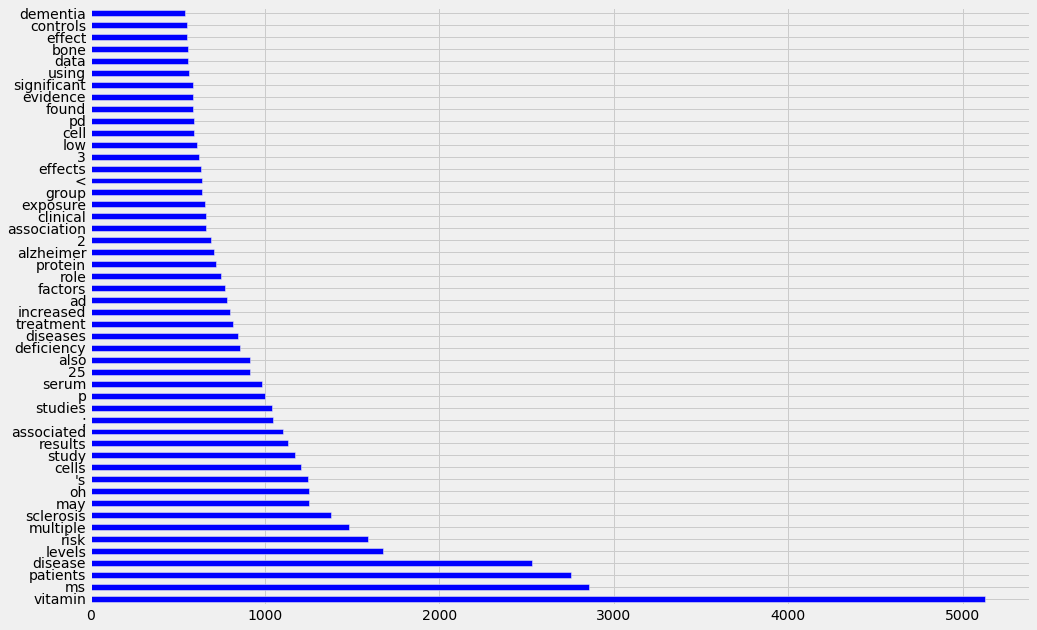

In [12]:
plt.figure(figsize = (15,10))
freqCounts[:50].plot(kind = 'barh')
#pylab.savefig('abstractwordFreq.png')

## Stemming vs Lemmatization - FreqDist

In [13]:
stemmedDF= stemming_words(processeddata)
stemmedDF.head()

PMID
27116719    [rec, maj, adv, develop, disease-modifying, tr...
27116717    [although, genet, suscept, explain, clust, mul...
27116242    [beyond, effect, bon, heal, vitamin, exert, ef...
27108944    [ultraviolet, b, uvb, light, suppress, develop...
27107558    [vitamin, d3, reg, gen, crit, hum, heal, defic...
Name: AB, dtype: object

In [29]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizedAB = stopped['AB'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [30]:
lemmatizedWF = pd.DataFrame(lemmatizedAB.apply(nltk.FreqDist))
unpacked_lemmatizedWF = unpack(lemmatizedWF, 'AB', 0)

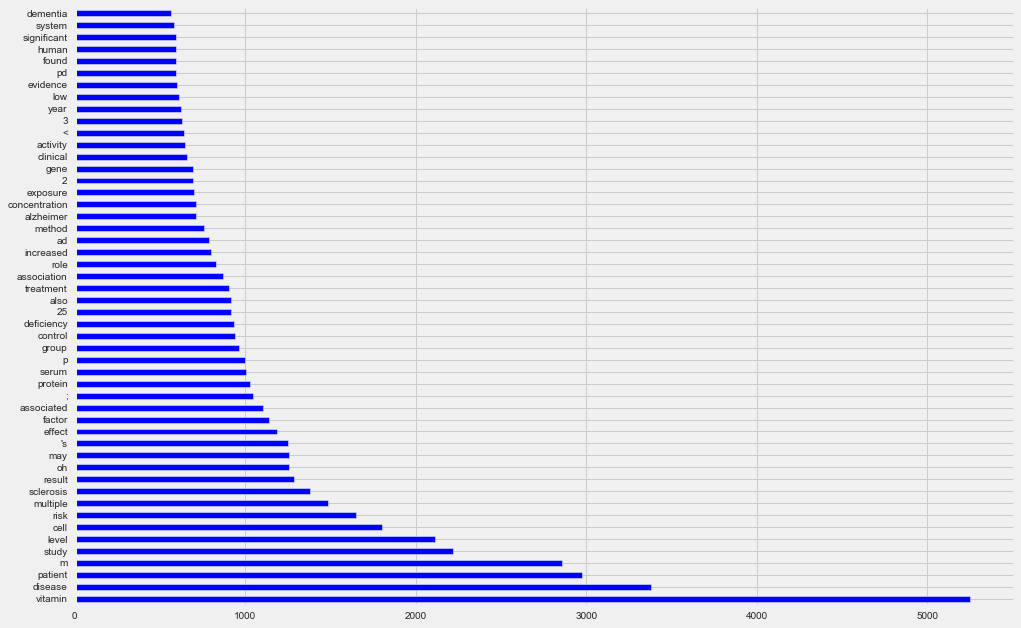

In [31]:
lemmatizedFreqCounts = unpacked_lemmatizedWF.sum(axis = 0)
lemmatizedFreqCounts.sort(ascending= False)
plt.figure(figsize = (15,10))
lemmatizedFreqCounts[:50].plot(kind = 'barh')
#pylab.savefig('lemmatizedFreqDist.png')

In [32]:
from nltk.stem import *
st = LancasterStemmer()

stemmedAB = stopped['AB'].apply(lambda x: [st.stem(word) for word in x])
stemmedWF = pd.DataFrame(stemmedAB.apply(nltk.FreqDist))
unpacked_stemmedWF = unpack(stemmedWF, 'AB', 0)

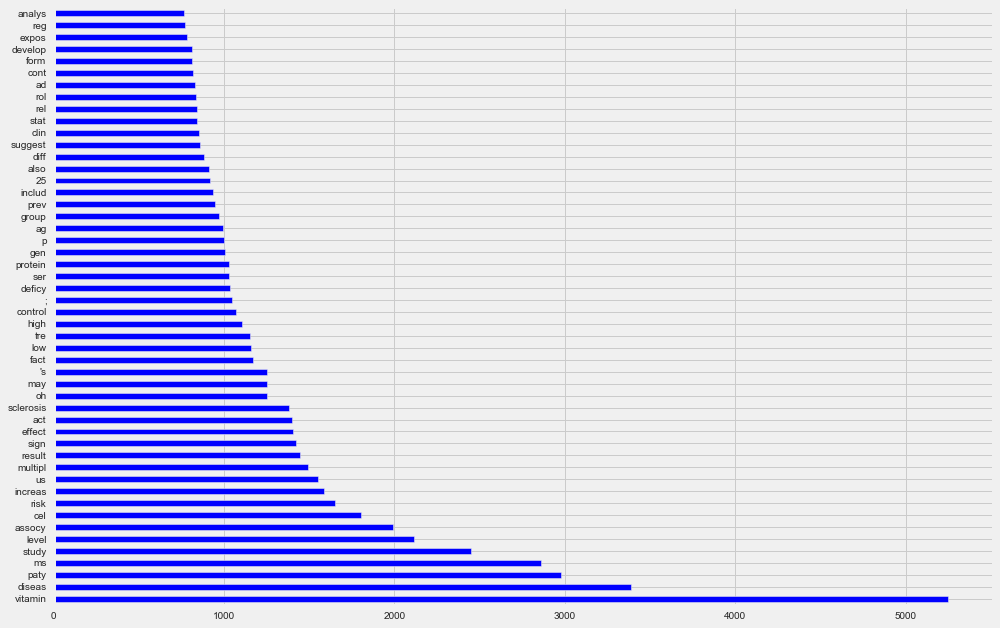

In [33]:
stemmedFreqCounts = unpacked_stemmedWF.sum(axis = 0)
stemmedFreqCounts.sort(ascending= False)
plt.figure(figsize = (15,10))
stemmedFreqCounts[:50].plot(kind = 'barh')
#pylab.savefig('stemmedFreqDist.png')

## Most common Nouns 

In [14]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

In [15]:
#findNN = pd.DataFrame(tagged.apply(lambda x: findtags('NN', x)))

def unpackseries(words):
    for tag in sorted(words):
        return(tag, words[tag])

#new = findNN['AB'].apply(lambda x: unpackseries(x))       
#findNN['AB'].apply(lambda x: x.get('NNS'))

In [146]:
{'NNS': [('factors', 3), ('compounds', 2), ('treatments', 2), ('designs', 1), ('aspects', 1)], 
 'NN': [('ms', 5), ('treatment', 3), ('development', 2), ('disease', 2), ('chain', 1)]}

In [16]:
## soup data
tokenedsoup = [word_tokenize(x) for x in allabstracts]
taggedsoup = [nltk.pos_tag(x) for x in tokenedsoup]

In [17]:
NNtaggedsoup = [findtags('NN', x) for x in taggedsoup]

In [18]:
from collections import Counter
NNtaggedsoupdf = pd.DataFrame(NNtaggedsoup)
NNonly = NNtaggedsoupdf['NN'].tolist()
NNPonly = NNtaggedsoupdf['NNP'].tolist()
NNPSonly = NNtaggedsoupdf['NNPS'].tolist()
NNSonly = NNtaggedsoupdf['NNS'].tolist()

nounsonly = NNSonly + NNPSonly + NNSonly  + NNPonly

In [19]:
NNonlydict = [dict(x) for x in NNonly]
count = Counter()
for d in NNonlydict:
    count+= Counter(d)
nouncounts = pd.Series(count)

In [20]:
NNonlydict[:5]

[{'chain': 1, 'development': 2, 'disease': 2, 'ms': 5, 'treatment': 3},
 {'briefly': 1, 'evidence': 1, 'frequency': 1, 'ms': 3, 'risk': 4},
 {'ad': 3, 'brain': 2, 'd': 8, 'decline': 2, 'vitamin': 6},
 {'d3': 3, 'eae': 6, 'ko': 3, 'mice': 6, 'nbuvb': 3},
 {'d3': 9, 'expression': 7, 'gene': 6, 'vitamin': 11, 'zinc': 6}]

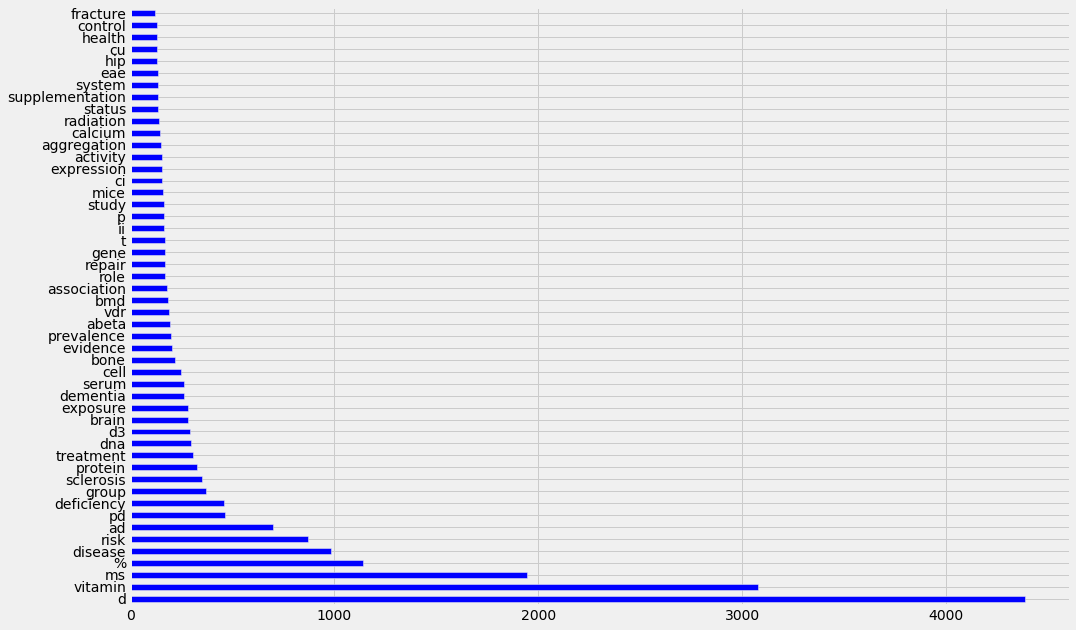

In [22]:
nouncounts.sort(ascending = False)
plt.figure(figsize=(15,10))
nouncounts[:50].plot(kind = 'barh')
#pylab.savefig('nounOnlyfreqdist.png')

## Noun Trends

In [23]:
NNtaggedsoupdf  =  pd.DataFrame(NNtaggedsoup)
#join PMID to Nouns
nounsDF = pmiddf.join(NNtaggedsoupdf).set_index('PMID')
nounsDF.head()

,NN,NNP,NNPS,NNS
PMID,,,,
27116719,"[(ms, 5), (treatment, 3), (development, 2), (d...",NaN,NaN,"[(factors, 3), (compounds, 2), (treatments, 2)..."
27116717,"[(risk, 4), (ms, 3), (briefly, 1), (evidence, ...",NaN,NaN,"[(associations, 1), (families, 1), (predictors..."
27116242,"[(d, 8), (vitamin, 6), (ad, 3), (brain, 2), (d...",NaN,NaN,"[(studies, 3), (effects, 3), (adults, 2), (imp..."
27108944,"[(eae, 6), (mice, 6), (ko, 3), (nbuvb, 3), (d3...",NaN,NaN,"[(patients, 1), (levels, 1), (lamps, 1), (scor..."
27107558,"[(vitamin, 11), (d3, 9), (expression, 7), (zin...","[(-1758/-1723, 1)]",NaN,"[(genes, 4), (vitamin, 2), (ngs, 2), (sequence..."


In [87]:
#import fulldataset
fulldata = pd.read_csv('dataframe.csv', low_memory =  False).set_index('PMID')

#Get dates
datedata = fulldata['DA'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m%d'))
#set dates to YYYYmm
datedata = pd.DataFrame(datedata.apply(lambda x: int(100*x.year + x.month)))
datedata = pd.DataFrame(datedata['DA'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m')))
#join dates to DF
#datesplusnouns = datedata.join(nounsDF)

In [86]:
def convert_to_dict(item):
    if type(item) is not float:
        return dict(item)
    else:
        return({'NA': 0})
def count_my_words(entry):
    c = Counter()
    for word in entry:
        c += Counter(word)
        return c

#temp =temp['NNP'].apply(lambda x: convert_to_dict(x))
#datesplusnouns['NNPS'].apply(lambda x: convert_to_dict(x))
#datesplusnouns['NNS'].apply(lambda x: convert_to_dict(x))

In [88]:
datesplusnouns = pd.DataFrame(nounsDF['NN'].apply(lambda x: convert_to_dict(x)))
datesplusnouns = datesplusnouns.join(datedata)
datesplusnouns = datesplusnouns.reset_index()
datesplusnouns.head()

,PMID,NN,DA
0,27116719,"{u'development': 2, u'chain': 1, u'treatment':...",2016-04-01
1,27116717,"{u'briefly': 1, u'frequency': 1, u'risk': 4, u...",2016-04-01
2,27116242,"{u'ad': 3, u'brain': 2, u'decline': 2, u'd': 8...",2016-04-01
3,27108944,"{u'ko': 3, u'mice': 6, u'eae': 6, u'd3': 3, u'...",2016-04-01
4,27107558,"{u'gene': 6, u'expression': 7, u'vitamin': 11,...",2016-04-01


In [89]:
allunpacked = unpack(datesplusnouns, 'NN', 0)

In [93]:
## select top 8 and control (p)

top5words = allunpacked[['p', 'melanoma','disease','ms','ad','pd', 'dopamine', 'd3', 'd','DA']]

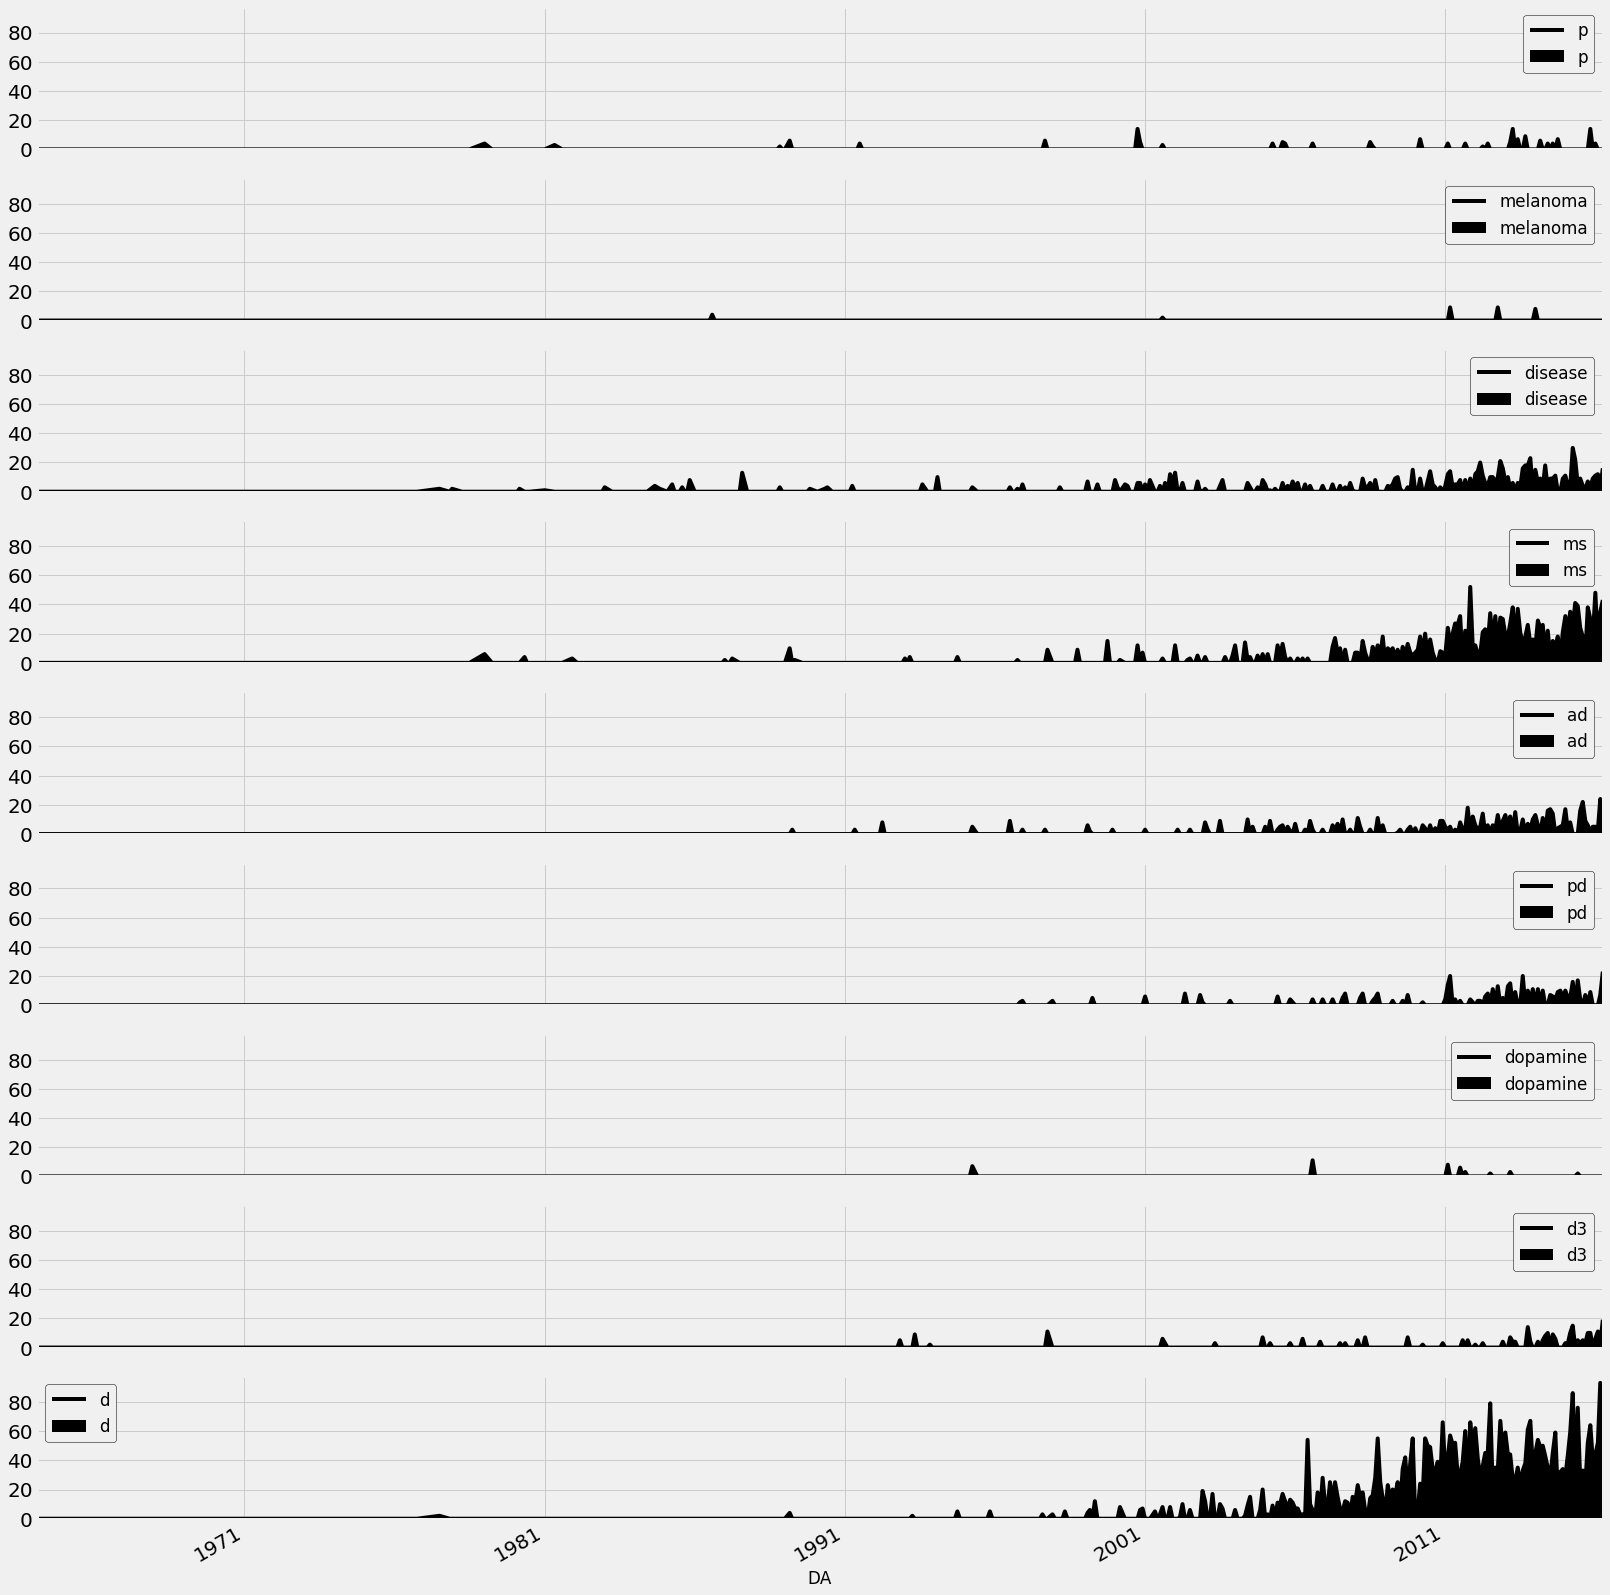

In [114]:
trending5 = top5words.groupby('DA').agg(np.sum)
plt.figure(figsize = (25,10))
#plt.plot(trending5, 'o')
trending5.plot(kind = 'area',subplots= True, figsize =(25,30), sharey=True, fontsize= 20, legend = True, colormap="cubehelix")
#plt.title('Trending words')
#plt.legend(trending5.columns, loc ='best')
#pylab.savefig('trendspernoun.png', bbox_inches='tight')

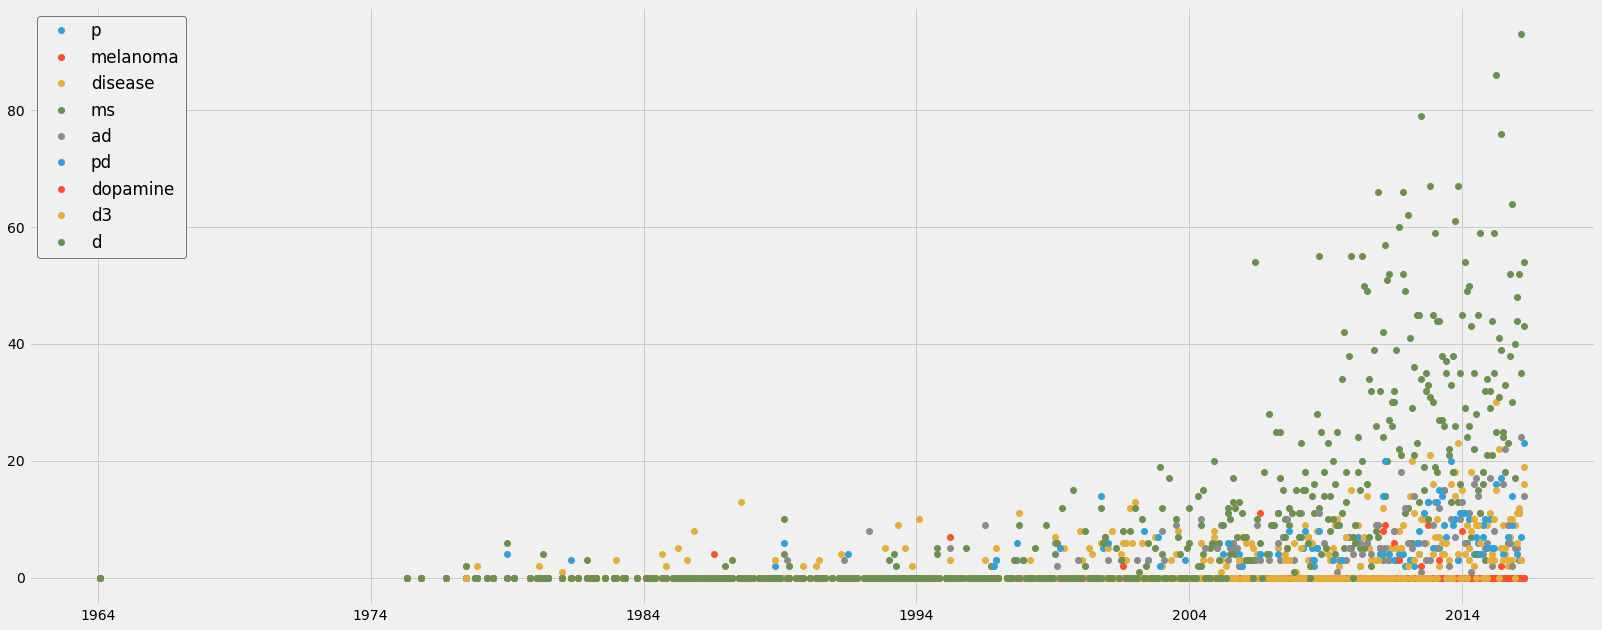

In [113]:
trending5 = top5words.groupby('DA').agg(np.sum)
plt.figure(figsize = (25,10))
plt.plot(trending5, 'o')
#trending5.plot(kind = 'area',subplots= True, figsize =(25,30), sharey=True)
#plt.title('Trending words')
plt.legend(trending5.columns, loc ='best')
#pylab.savefig('trends.png',bbox_inches='tight' )

In [199]:
dg = pd.DataFrame( [ [1,10] , [1,15] , [1,13] , [2,14] , [2,16] ] , columns=['ID','VALUE'] )

def seriesFeatures(series):
    dico = dict()
    dico['feature1'] = len(series)
    dico['feature2'] = series.sum()
    return dico

grouped2 = dg.groupby(['ID'])
dh = grouped2['VALUE'].agg( { 'all_features' : lambda s: seriesFeatures(s) } )
dh.reset_index()

,ID,all_features
0,1,"{u'feature2': 38, u'feature1': 3}"
1,2,"{u'feature2': 30, u'feature1': 2}"


In [202]:
grouped = datesplusnouns.groupby('DA')

grouped.apply(lambda s: s)

,NN,DA
PMID,,
27116719,"{u'development': 2, u'chain': 1, u'treatment':...",201604
27116717,"{u'briefly': 1, u'frequency': 1, u'risk': 4, u...",201604
27116242,"{u'ad': 3, u'brain': 2, u'decline': 2, u'd': 8...",201604
27108944,"{u'ko': 3, u'mice': 6, u'eae': 6, u'd3': 3, u'...",201604
27107558,"{u'gene': 6, u'expression': 7, u'vitamin': 11,...",201604
27096068,"{u'ip': 3, u'memory': 3, u'group': 9, u'd3': 5...",201604
27091700,{u'NA': 0},201604
27090608,"{u'%': 3, u'confidence': 3, u'ng/ml': 3, u'd':...",201604
27077324,"{u'hut5': 3, u'practice': 3, u'hut1': 3, u'blo...",201604


In [201]:
counteddf = pd.DataFrame(countedGroups)
counteddf.columns = ['Count']

In [166]:
counteddf['Count'].sum()

6332.0

## Commonly co-occuring words

In [115]:
# concordance with: association
# Should use non-stopped df


concordance_text = splitData['AB'].apply([map(lambda x: x-5 if (x-left_margin)>0 else 0,[offset])[0]:offset+right_margin]
                        for offset in c.offsets(target_word)])


textData = concordanceData['AB'].apply(nltk.Text)

SyntaxError: invalid syntax (<ipython-input-115-0e943292321a>, line 5)

In [116]:
from nltk.app import concordance
allabstracts2 = [nltk.word_tokenize(abstract) for abstract in allabstracts]
text = [nltk.Text(abstract) for abstract in allabstracts2]
concord = [abstract.concordance('increase') for abstract in text]

No matches
No matches
No matches
No matches
Displaying 3 of 3 matches:
eatment . an approximately 10-fold increase in ceruloplasmin and approximately
loplasmin and approximately 4-fold increase in haptoglobin gene expression sug
orter , with approximately 15-fold increase in expression . slc30a10 is critic
Displaying 1 of 1 matches:
n lipid peroxidation levels and an increase in cat activities . conclusion : c
No matches
No matches
No matches
No matches
No matches
No matches
No matches
Displaying 3 of 3 matches:
dicated that cigarette smoking may increase the risk of ms as well as accelera
e most commonly associated with an increase in relapses . relapse rates typica
hat obesity during adolescence may increase the risk of ms ; if confirmed , th
No matches
No matches
No matches
Displaying 1 of 1 matches:
e , 0.295 ) . thus , vitamin d may increase plasma abeta , particularly in old
No matches
No matches
No matches
Displaying 1 of 1 matches:
erfering rnas resulted in a 3-fold increase in

In [2]:
def get_all_phases_containing_tar_wrd(target_word, tar_passage, left_margin = 10, right_margin = 10):
    """
        Function to get all the phases that contain the target word in a text/passage tar_passage.
        Workaround to save the output given by nltk Concordance function
         
        str target_word, str tar_passage int left_margin int right_margin --> list of str
        left_margin and right_margin allocate the number of words/pununciation before and after target word
        Left margin will take note of the beginning of the text
    """
    # Source: https://simplypython.wordpress.com/2014/03/14/saving-output-of-nltk-text-concordance/
    ## Create list of tokens using nltk function
    tokens = nltk.word_tokenize(tar_passage)
     
    ## Create the text of tokens
    text = nltk.Text(tokens)
 
    ## Collect all the index or offset position of the target word
    c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())
 
    ## Collect the range of the words that is within the target word by using text.tokens[start;end].
    ## The map function is use so that when the offset position - the target range < 0, it will be default to zero
    concordance_txt = ([text.tokens[map(lambda x: x-5 if (x-left_margin)>0 else 0,[offset])[0]:offset+right_margin]
                        for offset in c.offsets(target_word)])
                         
    ## join the sentences for each of the target phrase and return it
    return [''.join([x+' ' for x in con_sub]) for con_sub in concordance_txt]

In [3]:
import csv

def csv_writer(writelist,filename):
    newseries = pd.Series(writelist)
    newseries.to_csv(filename)

In [4]:
concord2 = get_all_phases_containing_tar_wrd('increase', joinedText)
increaseFreq = frequencyDist_associated_words(concord2)
increaseFreqdf = pd.Series(increaseFreq)
increaseFreqdf.sort(ascending = False)

plt.figure(figsize = (10,30))
increaseFreqdf[:100].plot(kind = 'barh')
#pylab.savefig('wordassociation-increase.png')

NameError: name 'joinedText' is not defined

In [122]:
csv_writer(concord2, 'phasescontaining-increasing.csv')

In [153]:
concord_decrease = get_all_phases_containing_tar_wrd('decrease', joinedText)
#decreaseFreq = frequencyDist_associated_words(concord_decrease)
#decreaseFreqdf = pd.Series(decreaseFreq)
#decreaseFreqdf.sort(ascending = False)
#plt.figure(figsize = (10,30))
#decreaseFreqdf[:100].plot(kind = 'barh')
#pylab.savefig('wordassociation-decrease.png')

In [152]:
csv_writer(concord_decrease, 'phasescontaining-decrease.csv')

In [160]:
# for associate|associated |association
concord_associate = get_all_phases_containing_tar_wrd('associate', joinedText)
concord_associated = get_all_phases_containing_tar_wrd('associated', joinedText)
concord_association = get_all_phases_containing_tar_wrd('association', joinedText)

concord_total_associat = concord_associate + concord_associated + concord_association

#associateFreq = frequencyDist_associated_words(concord_total_associat)
#associateFreqdf = pd.Series(associateFreq)
#associateFreqdf.sort(ascending = False)
#plt.figure(figsize = (10,30))
#associateFreqdf[:100].plot(kind = 'barh')
#pylab.savefig('wordassociation-associate.png')

In [155]:
csv_writer(concord_total_associat, 'phasescontaining-associate.csv')

## n-grams

In [126]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = processeddata.apply(lambda x: BigramCollocationFinder.from_words(x))

In [130]:
# Naive bi-grams
bigram = finder.apply(lambda df: df.nbest(bigram_measures.pmi, 20))
# Naive tri-grams
Trifinder = processeddata.apply(lambda x: TrigramCollocationFinder.from_words(x))
trigram = Trifinder.apply(lambda df: df.nbest(trigram_measures.pmi, 20))

In [137]:
trigram

PMID
27116719    [(;, hence, urgent), (although, exact, role), ...
27116717    [(among, vitamin, status), (causality, associa...
27116242    [(although, randomized, placebo-controlled), (...
27108944    [(1,25-, oh, 2d3), (actually, counteracts, sup...
27107558    [(-1758/-1723, relative, transcription), (10, ...
27096068    [(21, days, post), (7, 21, days), (attempt, ma...
27090608    [(0.59-, 2.23, >), (17, years, used), (2.23, >...
27077324    [(3rd, 5th, minutes), (;, whereas, albumin), (...
27077158    [(clinical, effectiveness, vitamin), (effectiv...
27070218    [(activity, response, therapy), (applied, prac...
27063628    [(-2.5, thirty, one), (4.0, majority, 66), (66...
27056859    [(clinical, diagnosis, associated), (close, me...
27049563    [(3, folds, greater), (;, p=0.027, contributed...
27045883    [(169, original, articles), (1960, 2012, acces...
27037181    [(0.003, affected, eyes), (0.036, conclusion, ...
27035899    [(alcohol, high, coffee), (antigen, genes, con...
270

In [139]:
# token all soup
stopWords = stopwords.words('english')+['.', '(', ')', '=', ',', '-', '%', ':', 'in']
tokendata = word_tokenize(joinedText)
stoppeddata = [x for x in joinedText if x not in stopWords]

In [141]:
#stem text
st= LancasterStemmer()
stemmedWords= [st.stem(item) for item in stoppeddata]

In [142]:
#Naive bigram
NaiveBigram = [BigramCollocationFinder.from_words(stemmedWords)]
NaiveBigramcounts =  [x.nbest(bigram_measures.pmi, 30) for x in NaiveBigram]

In [144]:
NaiveBigramcounts

[[('_', '{'),
  ('>', '_'),
  ('}', '<'),
  ('4', '@'),
  ('+', '/'),
  ('6', '@'),
  ('>', '/'),
  ('$', '6'),
  ('_', '2'),
  ('{', '3'),
  ('1', '_'),
  ('~', '7'),
  ('[', ']'),
  ('$', '4'),
  ('"', '"'),
  ('3', '}'),
  ('?', '\n'),
  ('*', '1'),
  ('$', '1'),
  ('>', '>'),
  ('2', '5'),
  ('1', '*'),
  ('~', '4'),
  ('/', '_'),
  (']', ';'),
  ('9', '5'),
  ('0', '0'),
  ('~', '2'),
  ('9', '9'),
  ('<', '/')]]

In [146]:
#Naive bigram
NaiveTrigram = [TrigramCollocationFinder.from_words(stemmedWords)]
NaiveTrigramcounts =  [x.nbest(trigram_measures.pmi, 30) for x in NaiveTrigram]

In [147]:
NaiveTrigramcounts

[[('>', '_', '{'),
  ('_', '{', 'l'),
  ('}', '<', '/'),
  ('}', ' ', '{'),
  ('3', '4', '@'),
  ('$', '6', '7'),
  ('4', '6', '@'),
  ('/', '/', '_'),
  ('9', '3', '}'),
  ('"', "'", '"'),
  ('1', '_', '2'),
  ('[', '7', ']'),
  ('~', '7', '0'),
  ('*', '1', '5'),
  ('$', '4', '0'),
  ('>', '/', '7'),
  ('$', '1', '2'),
  ('~', '4', '0'),
  ('1', '*', '1'),
  ('>', '/', '6'),
  ('l', '>', '_'),
  ('>', '/', '3'),
  ('2', '3', '}'),
  ('*', 'g', '*'),
  ('4', '@', 'u'),
  ('~', '1', '9'),
  ('h', '}', '<'),
  ('[', '9', '5'),
  ('z', '[', ']'),
  ('[', 'h', ']')]]

In [148]:
# increase N-grams
tokenincrease = [word_tokenize(x) for x in concord2]
stopincrase= []
for item in tokenincrease:
    for word in item:
        if word not in stopWords:
            stopincrase.append(word)

In [158]:
#trigram increase
increaseTrigram = [TrigramCollocationFinder.from_words(stopincrase)]
increaseTrigramcounts =  [x.nbest(trigram_measures.raw_freq, 30) for x in increaseTrigram]

In [159]:
increaseTrigramcounts

[[('may', 'increase', 'risk'),
  ('10', 'nmol/l', 'increase'),
  ('increase', '25', 'oh'),
  ('increase', 'magnetic', 'moment'),
  ('increase', 'risk', 'ms'),
  ('25', 'oh', 'levels'),
  ('increase', 'ms', 'risk'),
  ('per', '10', 'nmol/l'),
  ('alzheimer', "'s", 'disease'),
  ('increase', 'fracture', 'risk'),
  ('increase', 'number', 'residents'),
  ('increase', 'serum', '25'),
  ('serum', '25', 'oh'),
  ('vitamin', 'may', 'increase'),
  ('658-fold', 'increase', 'magnetic'),
  ('cd4', '+', 'cd25'),
  ('cm', 'increase', 'magnetic'),
  ('could', 'increase', 'risk'),
  ('electron', 'spin', 'provides'),
  ('frequency', 'cm', 'increase'),
  ('increase', '1', 'sd'),
  ('increase', 'bmd', 'vitamin'),
  ('increase', 'calcium', 'vascular'),
  ('increase', 'risk', 'ms.'),
  ('increase', 'risk', 'pd'),
  ('increase', 'serum', 'calcium'),
  ('iron', 'without', 'proper'),
  ('magnetic', 'moment', 'electron'),
  ('magnetic', 'moment', 'resonant'),
  ('moment', 'electron', 'spin')]]

In [161]:
# decrease N-grams
tokenasso = [word_tokenize(x) for x in concord_total_associat]
stopasso= []
for item in tokenasso:
    for word in item:
        if word not in stopWords:
            stopasso.append(word)

In [162]:
#trigram assoc
assoTrigram = [TrigramCollocationFinder.from_words(stopasso)]
assoTrigramcounts =  [x.nbest(trigram_measures.raw_freq, 30) for x in assoTrigram]
assoTrigramcounts

[[('associated', 'increased', 'risk'),
  ('multiple', 'sclerosis', 'ms'),
  ('vitamin', 'deficiency', 'associated'),
  ('alzheimer', "'s", 'disease'),
  ('association', 'vitamin', 'deficiency'),
  ('risk', 'multiple', 'sclerosis'),
  ('vitamin', 'levels', 'associated'),
  ('associated', 'multiple', 'sclerosis'),
  ('25', 'oh', 'levels'),
  ('associated', 'alzheimer', "'s"),
  ('association', '25', 'oh'),
  ('parkinson', "'s", 'disease'),
  ('associated', 'reduced', 'risk'),
  ('vitamin', 'status', 'associated'),
  ('associated', 'decreased', 'risk'),
  ('association', 'vitamin', 'status'),
  ('associated', 'lower', 'risk'),
  ('associated', 'ms', 'risk'),
  ('genome-wide', 'association', 'studies'),
  ('levels', 'associated', 'increased'),
  ('low', 'vitamin', 'levels'),
  ('serum', '25', 'oh'),
  ('deficiency', 'associated', 'increased'),
  ("'s", 'disease', 'ad'),
  ('association', 'multiple', 'sclerosis'),
  ('association', 'vitamin', 'levels'),
  ('serum', 'vitamin', 'levels'),
  (

In [ ]:
# asssociation N-grams
tokendecrease = [word_tokenize(x) for x in concord_decrease]
stopdecrease= []
for item in tokendecrease:
    for word in item:
        if word not in stopWords:
            stopdecrease.append(word)

In [157]:
#trigram decrease
decraseTrigram = [TrigramCollocationFinder.from_words(stopdecrease)]
decreaseTrigramcounts =  [x.nbest(trigram_measures.raw_freq, 30) for x in decraseTrigram]
decreaseTrigramcounts

[[('decrease', 'reflects', 'alterations'),
  ('relaxivity', 'decrease', 'reflects'),
  ('t1', 'relaxivity', 'decrease'),
  ('accompanied', 'decrease', 't1'),
  ('alterations', 'redox', 'status'),
  ('alterations', 't1', 'relaxivity'),
  ('decrease', 't1', 'relaxivity'),
  ('process', 'accompanied', 'decrease'),
  ('reflects', 'alterations', 'redox'),
  ('reflects', 'alterations', 't1'),
  ('34', 'decrease', 'rate'),
  ('abeta', 'peptides', 'decrease'),
  ('aging', 'osteoporosis', 'decrease'),
  ('alzheimer', "'s", 'patients'),
  ('amyloid', 'plaques', 'decrease'),
  ('and/or', 'decrease', 'concentration'),
  ('associated', '34', 'decrease'),
  ('calcium', 'bone', 'well'),
  ('concentration', 'dopamine', 'human'),
  ('decrease', 'amyloid', 'plaques'),
  ('decrease', 'calcium', 'bone'),
  ('decrease', 'concentration', 'dopamine'),
  ('decrease', 'functional', 'capacity'),
  ('decrease', 'level', 'cytochromes'),
  ('dopamine', 'human', 'body'),
  ('human', 'body', 'reflect'),
  ('increase

## Bag of words approach: Term vectorising

    - counts per word per document, turns abstracts into sparse matrix (loses the ability to contextualise)
    
    - good for building a dictionary of terms used

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
listabstracts= processeddata.apply(lambda x:' '.join(x)).tolist()

In [26]:
vectorizer = CountVectorizer(analyzer= 'word',
                            tokenizer = None,
                            stop_words= None
                            )
datafeatures = vectorizer.fit_transform(listabstracts)
datafeaturesarray = datafeatures.toarray()
datafeatures[:2]

/Library/Python/2.7/site-packages/numpy-1.11.0-py2.7-macosx-10.11-intel.egg/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


<2x19206 sparse matrix of type '<type 'numpy.int64'>'
	with 128 stored elements in Compressed Sparse Row format>

In [79]:
tfVec = TfidfTransformer()
data_tfidf = tfVec.fit_transform(datafeatures)
data_tfidf= data_tfidf.toarray()
data_tfidf[:2]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [80]:
vocab = vectorizer.get_feature_names()
vecdist= np.sum(datafeaturesarray, axis = 0)
tfidfdist= np.sum(data_tfidf, axis = 0)

In [37]:
vecdata= pd.DataFrame(datafeaturesarray)
vecdata.columns= vocab
vecdata.head()

,00,000,00001,00002,00005,0001,0002,0003,0004,0005,...,zones,zonisamide,zoom,zooplankton,zopiclone,zorbax,zoster,zuclopenthixole,zusanli,zwitterionic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


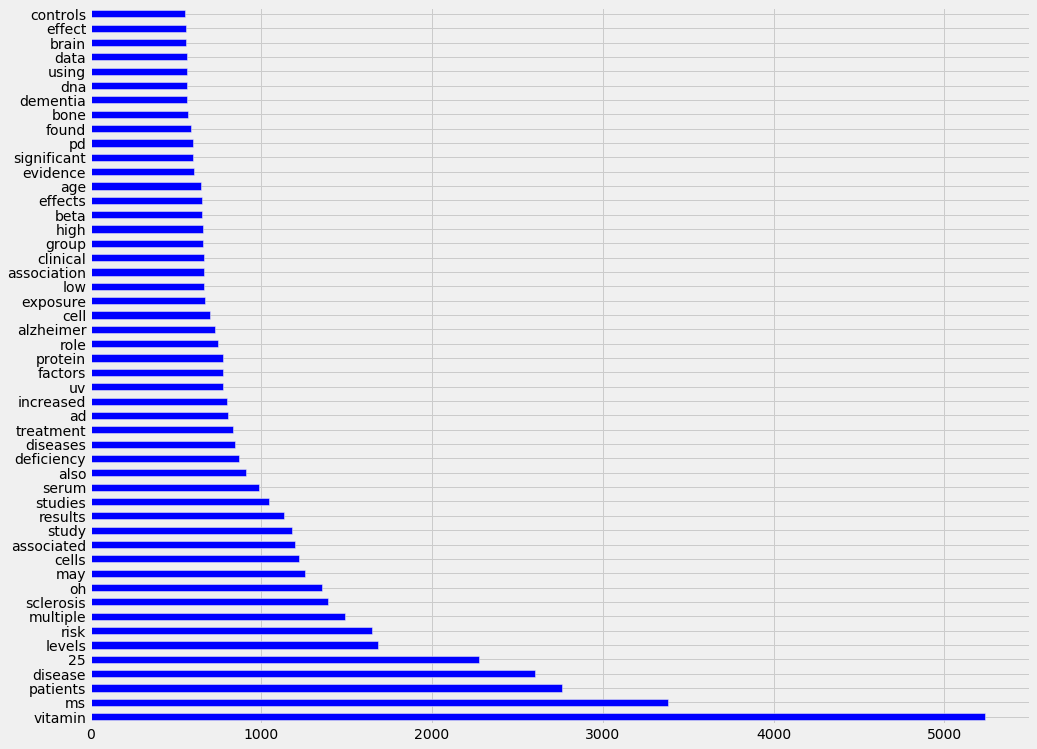

In [72]:
summedvec = vecdata.sum(axis = 0)
summedvec.sort(ascending = False, inplace= True)
summedvec[:50].plot(kind = 'barh', figsize = (15, 12))
#pylab.savefig('countvectorsBOW.png')

## TFIDF: Term Freqency - Inverse Document Frequency

    -  Corrects term frequency by document frequency -- higher weights to terms repeatedly mentioned across documents rather than within documents  ie. mentioning a condition several times per abstract
    
    - Controls for terms which are mainly mentioned many times within a subset of articles

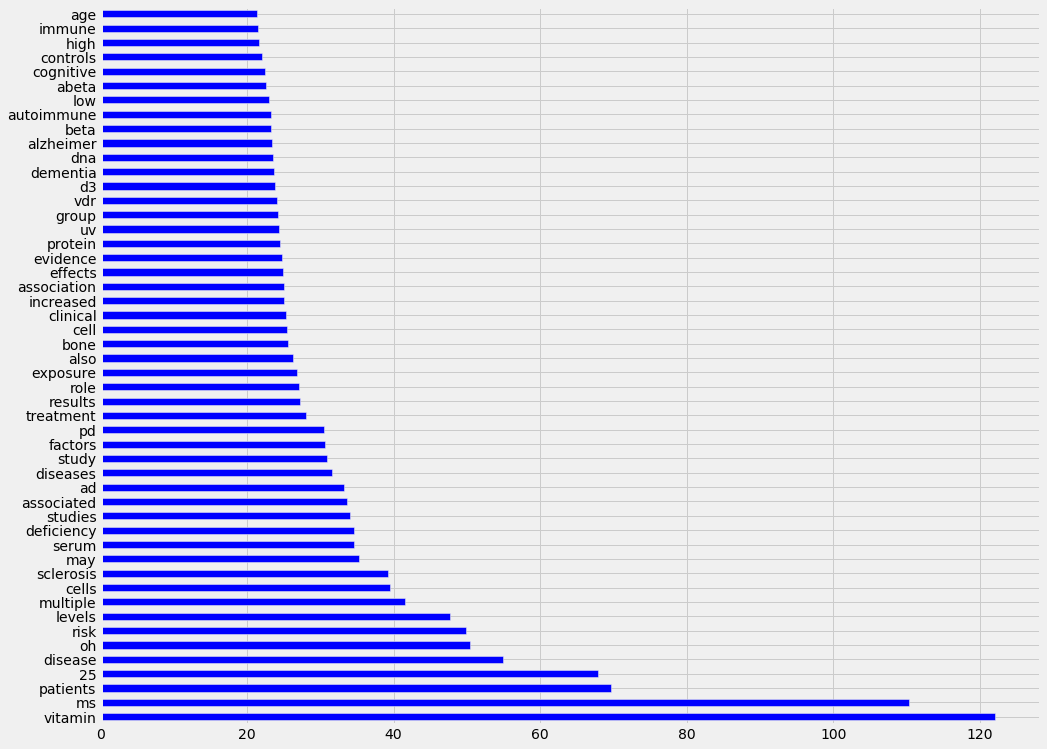

In [83]:
tfidf_data = pd.DataFrame(data_tfidf)
tfidf_data.columns= vocab
summed_tfidf= tfidf_data.sum(axis = 0)
summed_tfidf.sort(ascending= False)
summed_tfidf[:50].plot(kind='barh',  figsize = (15,12))
#pylab.savefig('tfidfBOW.png')